In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda is available


## Experiment setup

In [2]:
import wandb 
from datetime import datetime
import pandas as pd

experiment_log = []

# function version
def save_experiment(outfolder="./runs"):
    run_name = "run-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    os.makedirs(outfolder, exist_ok=True)
    os.makedirs(os.path.join(outfolder, run_name), exist_ok=True)
    keys = experiment_log[0].keys()
    for key in keys:
        np.save(os.path.join(outfolder, run_name, f"{key}.npy"), np.array([log.get(key, None) for log in experiment_log]))

    df = pd.DataFrame(experiment_log)
    df.to_csv(os.path.join(outfolder, run_name, "log.csv"), index=False)

    print(f"Experiment saved to {os.path.join(outfolder, run_name)}")

def init_experiment(config):
    wandb.init(
        project="rug-drl-catchgame",
        config=config,
    )

def terminate_experiment(save=True):
    wandb.finish()
    if save:
        save_experiment()

def log(data):
    experiment_log.append(data)
    print("; ".join([f"{k}: {v}" for k, v in data.items()]))
    wandb.log(data)



In [3]:
from modules.dqn.network import QNetworkConv
from world import CatchEnv

n_actions = 3
n_episodes = 1000
batch_size = 512

CATCH_ENV_NUM_STATES = 4
CATCH_ENV_WORLD_SIZE = (84, 84)
CATCH_ENV_POSSIBLE_ACTIONS = [0, 1, 2]

spatial_size = CATCH_ENV_WORLD_SIZE

dqn = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES, 
    spatial_size=spatial_size, 
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)
dqn_target = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES,
    spatial_size=spatial_size,
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)

In [4]:
env = CatchEnv()
env.reset_random()
next_state, reward, done = env.step(action=1)
next_state.shape, reward, done

((84, 84, 4), 0, False)

In [5]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(spatial_size),
    lambda x: x.unsqueeze(0),
    lambda x: x.type(torch.float32),
])

transforms(next_state).shape

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 4, 84, 84])

In [6]:
optimizer = optim.Adam(dqn.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

num_episodes = 1000
epsilon = 0.8
gamma = 0.9
epsilon_decay = 0.99


In [7]:
import random
from collections import deque

# Define a replay buffer class to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done_flags = zip(*batch)
        return states, actions, rewards, next_states, done_flags

# Initialize the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

def evaulate(epsilon=0.0, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset_random()
        state = transforms(state)
        done = False
        episode_reward = 0
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
            else:
                q_values = dqn(state.to(device))
                action = q_values.argmax().item()
            next_state, reward, done = env.step(action)
            next_state = transforms(next_state)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    return np.mean(rewards)

def sample_epsilon_exponential_decay(min_epsilon=0.01, max_epsilon=0.9, t=0.0, decay_rate=0.5):
    I = max_epsilon
    E = min_epsilon
    s = 10 * decay_rate
    theta = (np.exp(-s*t) -1) / (1 - np.exp(-s)) + 1
    return (I - E) * theta + E

### Training

In [8]:

init_experiment(config={
    "num_episodes": num_episodes,
    "batch_size": batch_size,
    "gamma": gamma,
    "epsilon_decay": epsilon_decay,
    "spatial_size": spatial_size,
})

################ TRAINING ################

best_performance = evaulate(epsilon=0.0, num_episodes=10)
log({"episode": 0, "epsilon": 0.0, "reward": best_performance})

for episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset_random()
    state = transforms(state)
    done = False
    
    done_i = 0

    while not done:
        # Choose an action using an epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
        else:
            q_values = dqn(state.to(device))
            action = q_values.argmax().item()
        
        # Take the action and observe the next state and reward
        next_state, reward, done = env.step(action)
        next_state = transforms(next_state)
        
        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer.buffer) > batch_size:
            states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
            # (batch, 4, 84, 84)
            # [(1, 4, 84, 84), ... ] -> (batch, 4, 84, 84)
            
            states = torch.cat(states).to(device)
            actions = torch.Tensor(actions).type(dtype=torch.int64).to(device)
            rewards = torch.Tensor(rewards).to(device)
            next_states = torch.cat(next_states).to(device)
            done_flags = torch.Tensor(done_flags).to(device)

            # Compute the target Q-values using the DDQN algorithm
            q_values = dqn(states)
            max_actions = q_values.argmax(dim=-1)
            
            with torch.no_grad():
                q_values_target = dqn_target(next_states)
            q_values_target = q_values_target.gather(1, max_actions.unsqueeze(-1)).squeeze(-1)
            q_values_target = rewards + gamma * q_values_target * (1 - done_flags)
            
            # Compute the current Q-values and the loss
            current_q_values = q_values.gather(1, torch.Tensor(actions).unsqueeze(-1)).squeeze(-1)
            loss = criterion(current_q_values, q_values_target.detach())
            
            # Update the DQN network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the target network
            if done_i % 10 == 0:
                dqn_target.load_state_dict(dqn.state_dict())
            done_i += 1
        
        # Update the state
        state = next_state

    # Evaluate the policy and save the results
    if episode % 10 == 0:
        mean_reward = evaulate(epsilon=0.0, num_episodes=10)
        epsilon = sample_epsilon_exponential_decay(t=mean_reward, decay_rate=0.3, max_epsilon=1)
        if mean_reward > best_performance:
            best_performance = mean_reward
            torch.save(dqn.state_dict(), "models/dqn_best.pt")
        log({"episode": episode, "mean_reward": mean_reward, "epsilon": epsilon})

################ TRAINING END ################

terminate_experiment()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: massaf (rug-ai-group). Use `wandb login --relogin` to force relogin


episode: 0; epsilon: 0.0; reward: 0.3


  0%|          | 1/1000 [00:00<02:51,  5.84it/s]

episode: 0; mean_reward: 0.3; epsilon: 0.3817216991062283


  2%|▏         | 16/1000 [00:00<00:28, 35.13it/s]

episode: 10; mean_reward: 0.2; epsilon: 0.5299195944432384


  3%|▎         | 30/1000 [00:00<00:22, 44.05it/s]

episode: 20; mean_reward: 0.1; epsilon: 0.7299658287281285


  4%|▎         | 36/1000 [00:01<00:26, 36.10it/s]

episode: 30; mean_reward: 0.2; epsilon: 0.5299195944432384


  4%|▍         | 41/1000 [00:01<00:29, 33.03it/s]

episode: 40; mean_reward: 0.2; epsilon: 0.5299195944432384


  5%|▌         | 51/1000 [00:03<02:27,  6.43it/s]

episode: 50; mean_reward: 0.3; epsilon: 0.3817216991062283


  6%|▌         | 61/1000 [00:08<06:13,  2.52it/s]

episode: 60; mean_reward: 0.3; epsilon: 0.3817216991062283


  7%|▋         | 71/1000 [00:13<08:24,  1.84it/s]

episode: 70; mean_reward: 0.4; epsilon: 0.27193399797388856


  8%|▊         | 81/1000 [00:19<08:20,  1.84it/s]

episode: 80; mean_reward: 0.3; epsilon: 0.3817216991062283


  9%|▉         | 91/1000 [00:24<08:16,  1.83it/s]

episode: 90; mean_reward: 0.2; epsilon: 0.5299195944432384


 10%|█         | 101/1000 [00:29<07:53,  1.90it/s]

episode: 100; mean_reward: 0.4; epsilon: 0.27193399797388856


 11%|█         | 111/1000 [00:34<08:20,  1.78it/s]

episode: 110; mean_reward: 0.5; epsilon: 0.19060126856829268


 11%|█▏        | 113/1000 [00:35<08:09,  1.81it/s]

In [ ]:
# load best 
dqn.load_state_dict(torch.load("models/dqn_best.pt"))

<All keys matched successfully>

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


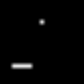

In [ ]:
# evluation
env = CatchEnv()
state = env.reset_random()
state = transforms(state)
video = []

while True:
    q_values = dqn(state.to(device))
    action = q_values.argmax().item()
    next_state, reward, done = env.step(action)
    next_state = transforms(next_state)
    state = next_state
    video.append(next_state.squeeze(0))
    if done:
        break

frames = []
video = torch.stack(video)
# shape (k iterations, 4 frames, 84, 84)
# put side to side resulting in (4 * k, 84, 84) without changing the order
video = video.permute(1, 0, 2, 3).reshape(4 * len(video), 84, 84)

# video is of shape (time, 84, 84)
# make a gif and display it
import imageio
from IPython.display import Image

imageio.mimsave("dqn_conv.gif", 255 * video.cpu().numpy())
Image(filename="dqn_conv.gif", format='png')